<a href="https://colab.research.google.com/github/TaliNatan/DSPS_TNatan/blob/main/HW5_TNatan/FitLineToGRBAfterGlow_mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#package used to display latex formuale
from IPython.display import Latex

import numpy as np
import pylab as pl
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

## reading in dataset

In [2]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/main/data/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


## plotting raw dataset

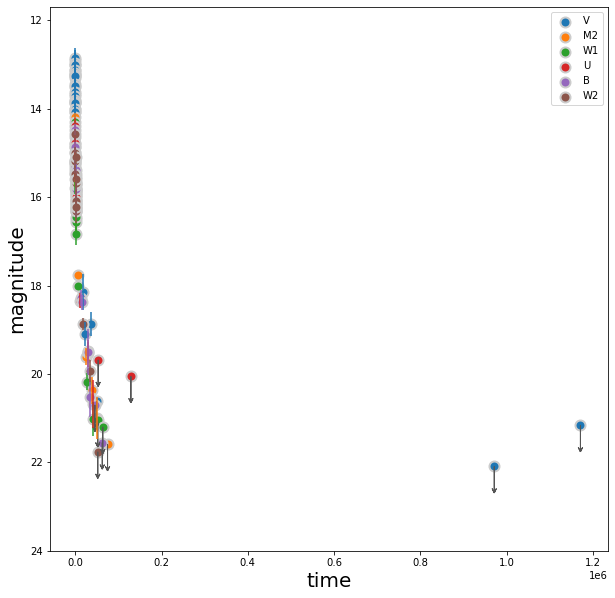

In [3]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

The above plot shows the magnitude versus time of a GRB afterglow. From this plot, we can see the magority of the data is between 0-0.2E6 seconds but two datapoints (possible outliers) are found around 0.95-1.2E6 seconds. Further, all the brightest GRBs (lowest magnitudes) are all found in the V (visible) filter. 

## create the log-time variable

In [4]:
grbAG["log_time"] = np.log10(grbAG["time"])

In [5]:
def plotlogtime(df, models=[]):
  '''
  plotting function
  :param df: pandas dataframe, original data
  :param models: list, names of model types

  :return ax: plotting parameters 
  '''
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "log_time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "log_time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].log_time,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  pl.ylim(24,11.7)
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

<AxesSubplot:xlabel='log time', ylabel='magnitude'>

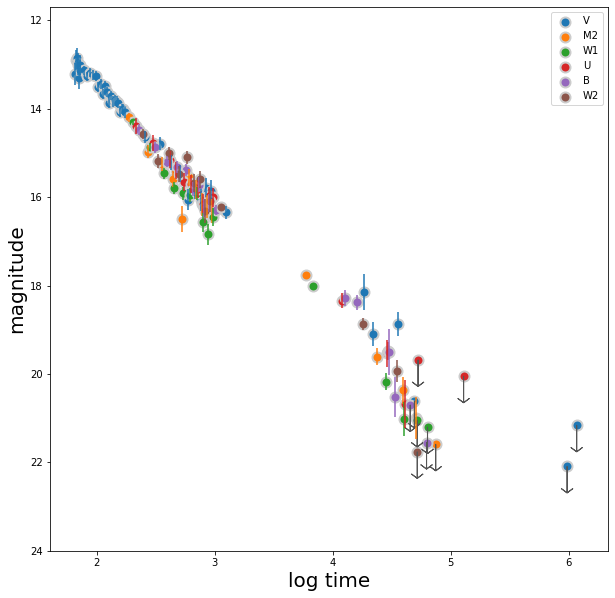

In [6]:
plotlogtime(grbAG)

The above plot shows the magnitude versus log time of GRB afterglows. From this plot, we can see that the relationship (in log log space (since magnitude is already a log scale)) is approximatly linear. Further, the data segments seems to be seperated into two different domains; one between 1 and 3 and another between 3.5 and 5 (I am not considering the outliers around 6).

## plotting data w/ log_time

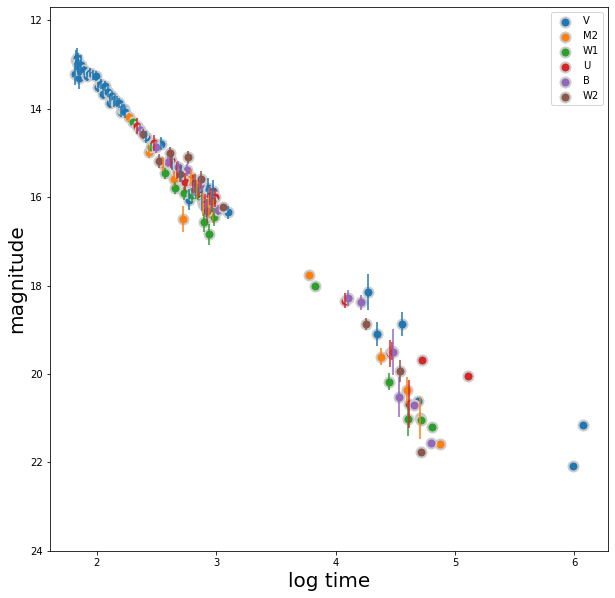

In [7]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "log_time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "log_time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].magerr, 0, 2,
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

The above plot shows the magnitude versus log time of GRB afterglows. From this plot, we can see that the relationship (in log log space (since magnitude is already a log scale)) is approximatly linear. Further, the data segments seems to be seperated into two different domains; one between 1 and 3 and another between 3.5 and 5 (I am not considering the outliers around 6). The only difference between this plot and the above plot is this one is missing the upper limit arrows.

## solving normal Eq.

In [8]:
grbAG_no_limit = grbAG.drop(grbAG[grbAG.upperlimit > 0].index)
grbAG_no_limit
grbAG = grbAG_no_limit

x = grbAG["log_time"].values
X = np.c_[np.ones(len(x)),x]
y = grbAG["mag"].values

theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("The best fit parameters from the Normal Equation: " + "intercept {:.2f}, slope {:.2f}".format(*theta_best))

The best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


## using sklearn LinearRegression

In [9]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

print(lr.fit(X,y))
print(lr.coef_)
print(lr.intercept_)

LinearRegression()
[0.         2.51199984]
8.582668233648771


## minimizing an objective function

In [10]:
def line(intercept, slope, x):
  '''
  calculate values on a line
  :param intercept: int, intercept value
  :param slope: int, slope value
  :param x: array, x values

  :return: y values of line
  '''
  
  return(slope * x + intercept)

def of(args, x, y):
  '''
  :param args: array, model arguments (parameters)
  :param x: array, x values
  :param y: array, y values

  :return: sum of the absolute value of the diff of y values from line values
  '''
  intercept, slope = args
  return(sum(np.abs(y-line(intercept, slope, x))))

# plt.plot(x,y,'.')
# plt.plot(x,line(8.225, 2.641, x), '-')
# plt.show()

initialGuess = (10,1)

l1_Solution = minimize(of, initialGuess, args=(x, y))
print(l1_Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1_Solution.x))

      fun: 26.303375653980027
 hess_inv: array([[ 1.44649213e-04, -5.21219482e-05],
       [-5.21219482e-05,  2.78023774e-05]])
      jac: array([-0.49906301, -2.45716882])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 224
      nit: 14
     njev: 72
   status: 2
  success: False
        x: array([8.22529391, 2.64072593])

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [11]:
def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''

    intercept, slope = args
    return(sum((y-line(intercept, slope, x))**2))

# plt.plot(x,y,'.', c = "k")
# plt.plot(x,line(8.225, 2.641, x), linestyle = 'dashed', c = "r", label = "L1")
# plt.plot(x,line(8.583, 2.512, x), linestyle = 'dotted', c = "b", label = "L2")
# plt.legend(loc = "upper left")
# plt.show()

initialGuess = (10,1)
l2Solution = minimize(l2, initialGuess, args=(x, y))

print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

      fun: 12.825987500725546
 hess_inv: array([[ 0.06254438, -0.02029726],
       [-0.02029726,  0.00711354]])
      jac: array([ 3.57627869e-07, -4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([8.58266844, 2.51199977])

best fit parameters from the minimization of L2: slope 8.58, intercept 2.51


In [12]:
def chi2(args, x, y, s):
    '''chi2 target function: returns value of chi2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)

    returns L2 sum of difference between prediction and data squared
    '''

    intercept, slope = args
    return(sum(((y-line(intercept, slope, x))**2)/s))
   

x = grbAG[grbAG.upperlimit == 0].log_time.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = (10,1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

      fun: 58.49837428948433
 hess_inv: array([[ 0.01113153, -0.00381294],
       [-0.00381294,  0.00139784]])
      jac: array([1.90734863e-06, 4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([8.58159557, 2.49968625])

best fit parameters from the minimization of the chi squared: slope 8.58, intercept 2.50


## plotting all solutions

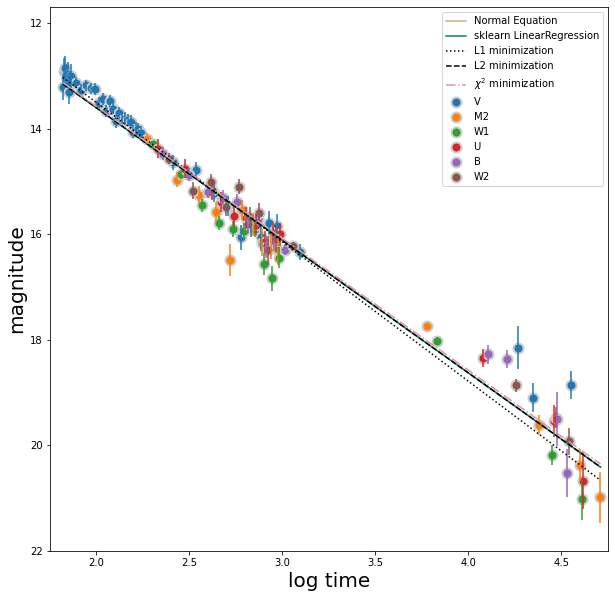

In [13]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    '''
    function for plotting line
    :param pars: list, slope and intercept values
    :param x: array, x values
    
    :return: plotting of a line
    '''
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.log_time.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.log_time,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1_Solution.x[::-1]), grbAG.log_time,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.log_time,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.log_time,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(22,11.7)
pl.xlim(1.75, 4.75)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

The above plot shows the magnitude versus log time of GRB afterglows with 5 different linear approxinations. From this plot, we can see that the relationship (in log log space (since magnitude is already a log scale)) does align visually with various linear fits. The outliers around log time 6 have been removed for fitting purposes.

## train-test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=421)
l2r = LinearRegression()
l2r.fit(X_train, y_train)
print(l2r.score(X_train, y_train))
print(l2r.score(X_test, y_test))

0.9715048527494905
0.9713551465585457


## Hw part 2 stuff

In [15]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

In [16]:
import emcee #import the package
emcee

<module 'emcee' from '/Users/tali/opt/anaconda3/lib/python3.9/site-packages/emcee/__init__.py'>

In [17]:
# LINE MODEL
def log_prior(theta):
  '''
  provides the posterior for line
  :param theta: list, slope and intercept values

  :return: either 0 or -infinity depending on tb, a1, and a2 values
  '''
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf

#log likelihood
def log_likelihood(theta, x, y, yerr):
  '''
  provides the likelyhood/probability for line
  :param theta: list, slope and intercept values
  :param x: array, independent variable
  :param y: array, dependent variable
  :param yerr: array, uncertainty of y values

  :return: log_likelihood value of a line
  '''
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)
  
#log posterior
def log_posterior(theta, x, y, yerr):
  '''
  provides the posterior for line fit
  :param theta: list, slope and intercept values
  :param x: array, independent variable
  :param y: array, dependent variable
  :param yerr: array, uncertainty of y values

  :return: log_posterior value of line
  '''
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [18]:
#initial guess
ig = [1,10]

#initialize N walkers
nwalkers = 32
ndim = len(ig)

pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) #the starting point for each walker is a small perturbation of the initial guess

print(pos.shape)

# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 5000, progress=True);

# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

print(samples.shape)

# to get statistical properties of the chains I will concatenate the 32 chains. This works _iff_ the chains are independent
# note: the chains are _assumed_ to be independent
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
print(mcmc)

(32, 2)


100%|██████████| 5000/5000 [00:05<00:00, 843.00it/s]

(5000, 32, 2)
[[2.4657868  2.47996468 2.49409529]
 [8.56019547 8.59942532 8.63975848]]


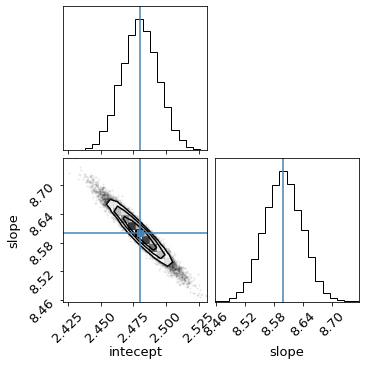

In [19]:
#plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters
!pip install corner
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["intecept", "slope"], truths=mcmc[:,1]);

The above corner plots show the dsitribution of slope and intercept values. From this, we can see that the slope and intercept values are constrained to unimodal distributions and the their relation to one another is very well definied in a linear relationship.

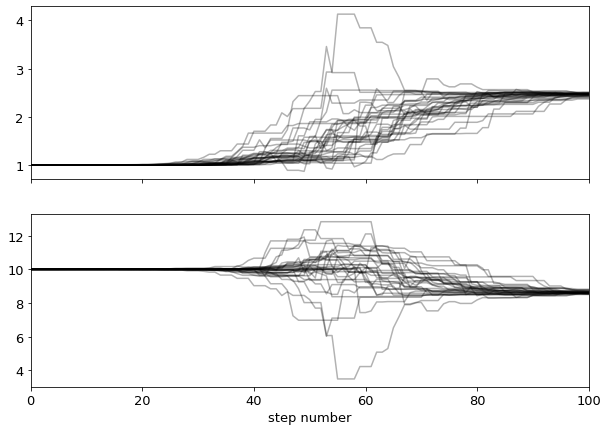

In [20]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

The above plot shows how 32 walkers with a initial guesses of slope = 10 and intercept = 1 converged over 100 steps to slope and intercept values of ~8.5 and ~2.5. Something we need to note is that had we only run the mcmc process for 20 steps, it would appear that our initial values were correct. A "long enough" step number is needed to converge to a correct answer. For this problem, it was around 100 steps but a longer time may have yeilded more precise results.

In [21]:
# save the mcmc results for later
mcmc_line = mcmc

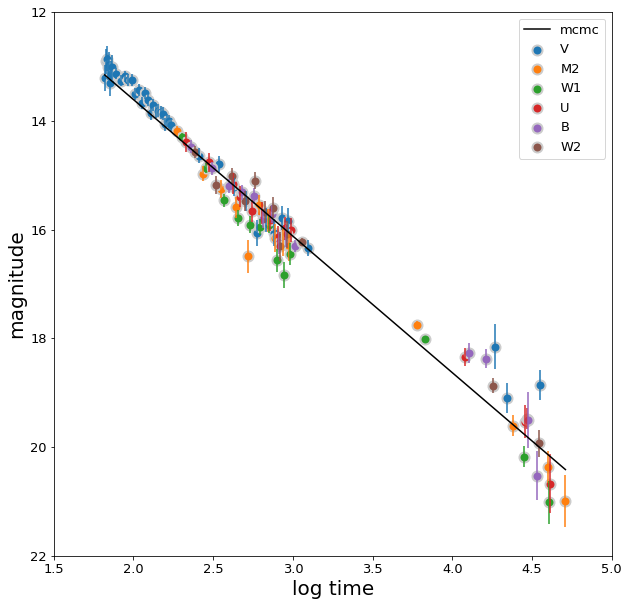

In [22]:
labels = ["intercept","slope"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

# ax.plot(np.arange(1.5,6,0.01),
#         bpl(ig, 10**np.arange(1.5,6,0.01)), ls="--", c="k",
#         label="MCMC")

#with the LinearRegression object I can also do
plt.plot(grbAG.log_time, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.log_time]), 'k-', label = 'mcmc')

plt.legend()

plt.ylim(22,12)
plt.xlim(1.5, 5)
plt.ylabel("magnitude", fontsize=20)
plt.xlabel("log time", fontsize=20);

The above plot shows the magnitude versus log time of GRB afterglow. A line produced with an mcmc method (32 walkers, initial guess of slope = 10, intercept = 1) is shown in black. A visual inspection shows that this line does an O.K. job of fitting the data but the slope seems too shallow for both portions of the data but this line does connect the regions well. Possibly, a single linear fit is not the best way of decribing this data.

## hw 3 part

In [23]:
t = grbAG[grbAG.upperlimit == 0].time.values
t.min(), t.max()

(66, 51257)

In [24]:
def bpl (theta, t):
  """broken power law model
  Input:
    theta: (array like) 4 parameters vector, see equation
    t: (array like) independent variable
  Return: model predictions for each x (array like)
  """
  tb, a1, a2, b = theta

  return b - np.log10((t/tb)**(-a1) + (t/tb)**(-a2))


In [25]:
def log_priorbpl(theta):
  '''
  provides the posterior for our broken power law fit
  :param theta: list, tb, a1, a2, and b values

  :return: either 0 or -infinity depending on tb, a1, and a2 values
  '''
  tb, a1, a2, b = theta
  if tb > 0 and a1 > 0 and a2 > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf
  
#log likelihood
def log_likelihood_bpl(theta, x, y, yerr):
  '''
  provides the likelyhood/probability for our broken power law fit
  :param theta: list, tb, a1, a2, and b values
  :param x: array, independent variable
  :param y: array, dependent variable
  :param yerr: array, uncertainty of y values

  :return: log_likelihood value of broken power law fit
  '''
  tb, a1, a2, b = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return np.sum(((y - bpl(theta, t))**2) / yerr**2)
  
#log posterior
def log_posterior(theta, x, y, yerr):
  '''
  provides the posterior for our broken power law fit
  :param theta: list, tb, a1, a2, and b values
  :param x: array, independent variable
  :param y: array, dependent variable
  :param yerr: array, uncertainty of y values

  :return: log_posterior value of broken power law fit
  '''

  lp = log_priorbpl(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood_bpl + log_prior
  return lp - log_likelihood_bpl(theta, x, y, yerr)

In [26]:
# ig = [0.2, 5, 1000, 20]
ig = [1000, 5, 20, 0.2]

#what does the minimize function need to take as arguments?
soln = minimize(log_likelihood_bpl, ig, args=(t, y, s))
soln

      fun: 217.46531456545029
 hess_inv: array([[ 2.70228728e-03,  7.94808336e-04,  2.97121901e-05,
         4.94579626e-05],
       [ 7.94808336e-04,  3.93575666e-03, -5.00501380e-04,
         4.86261245e-04],
       [ 2.97121901e-05, -5.00501380e-04,  3.79876726e-04,
        -1.59803948e-04],
       [ 4.94579626e-05,  4.86261245e-04, -1.59803948e-04,
         1.93336731e-04]])
      jac: array([-5.72204590e-06,  9.61303711e-04,  3.12805176e-03,  2.20489502e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 647
      nit: 75
     njev: 127
   status: 2
  success: False
        x: array([273.58855218,   3.54796797,   2.14569441,  15.04717783])

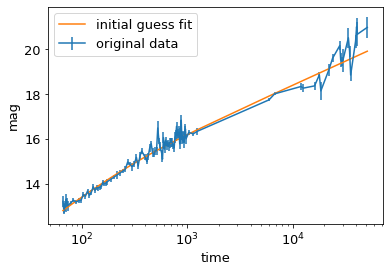

In [27]:
ig = soln.x # the initial guess for the MCMC

# plot the model as it looks with the initial guess values
pl.errorbar(t, y, yerr=s, label = 'original data')
pl.plot(t, bpl(ig, t), label = 'initial guess fit')
pl.xscale("log")
pl.xlabel("time")
pl.ylabel("mag")
pl.legend(loc = "upper left")

plt.show()

The above plot shows the broken power law fit w/ initial guesses with the raw data (with uncertainties). From this, we can see that the initial guess fit does a good job capturing the original data although in the higher-time domain, where uncertainties/scatter of data is greater, the fit it just o.k. (difficult to simply fit this area.)

In [28]:
# set the emcee hyperparameters

nwalkers, ndim = 32, len(ig)

pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, y, s))

# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 5000, progress=True);

# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

print(samples.shape)

# to get statistical properties of the chains I will concatenate the 32 chains. This works _iff_ the chains are independent
# note: the chains are _assumed_ to be independent
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
print(mcmc)

100%|██████████| 5000/5000 [00:08<00:00, 585.93it/s]


(5000, 32, 4)
[[234.4380764  283.60843478 350.46275589]
 [  3.40594139   3.52569313   3.65523808]
 [  2.09851515   2.13916929   2.17853755]
 [ 14.85826073  15.09081547  15.34278789]]


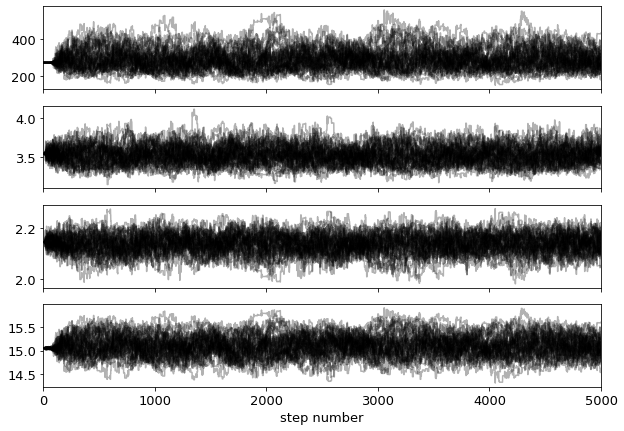

In [29]:
#plot the chains

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 5000)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

The above plot shows how 32 walkers sample the parameter space for all the variable (a1, a2, tb, and b). While these values do not converge over 5000 steps, the range of the walkers exploration is already quite constrained accept for tb which indicates that the value of the break time can be modeled with a wider range of values.

In [30]:
# to get statistical properties of the chains I will concatenate the 32 chains. This works _iff_ the chains are independent
# note: the chains are _assumed_ to be independent
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
print(mcmc[:,1])

[283.60843478   3.52569313   2.13916929  15.09081547]


/var/folders/q8/r398fm3j5k3fg08l9dj3529h0000gn/T/ipykernel_21626/4250659411.py:37: RuntimeWarning: divide by zero encountered in power
  mag = b - np.log10((z/tb)**(-a1) + (z/tb)**(-a2))


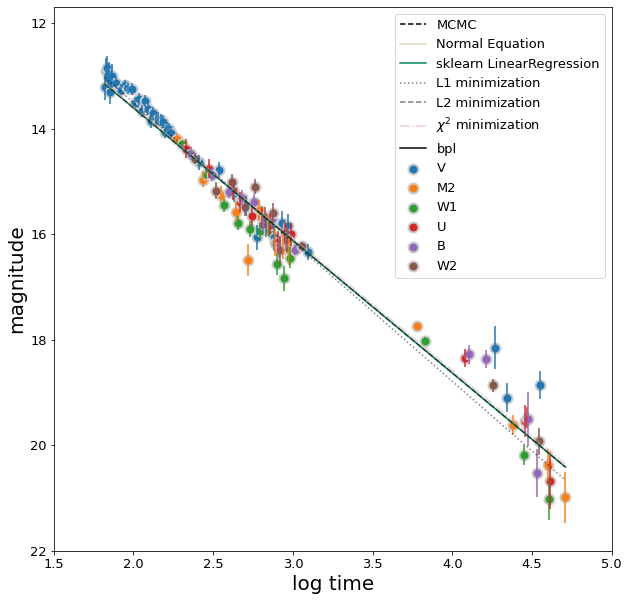

In [31]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG.log_time.values, line(mcmc[:,1][0], mcmc[:,1][1],
                            grbAG.log_time.values), ls="--", c="k", label="MCMC")
#normal equation
plotline((theta_best[::-1]), grbAG.log_time.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.log_time,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1_Solution.x[::-1]), grbAG.log_time,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.log_time,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.log_time,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

tb, a1, a2, b = 286.90594219, 3.5191303, 2.13888608, 15.10483258
z = np.arange(0, 0.2e6, 1)
mag = b - np.log10((z/tb)**(-a1) + (z/tb)**(-a2))

plt.plot(z,mag,'k-', label = 'bpl')

# plt.plot(grbAG.log_time, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.log_time]), 'k-', label = 'mcmc')

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc[2,1]))
pl.ylim(22,11.7)
pl.xlim(1.5, 5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

The above plot shows the mag versus logtime of GRB afterglow. The raw data is fitted with a number of different linear, simple exponential, and broken power law fits. Looking at all of these fits against the data, no one fit particularly stands out; they all seem to capture the data fine.

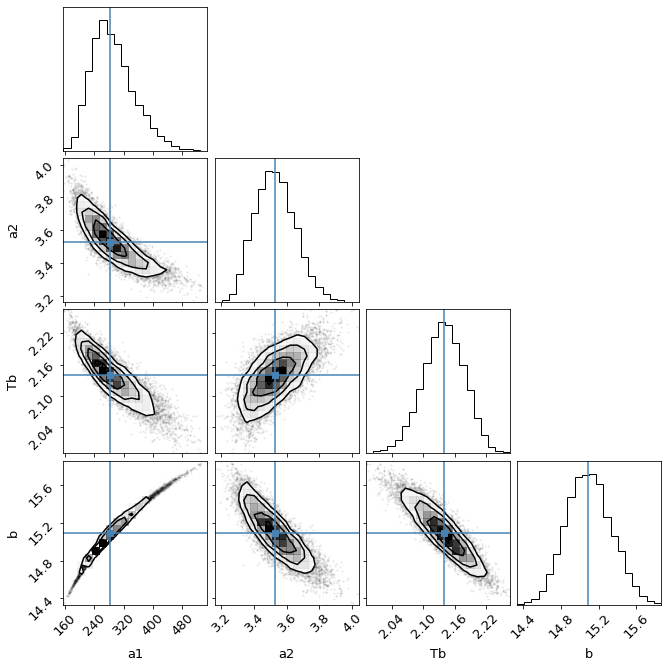

In [32]:
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["a1", "a2", "Tb", "b"], truths=mcmc[:,1]);

The above corner plots show the distribution of the different variables relative to one another. All the plot show approximately guassian distributions. For the bottom left plot, we see that the relationship between variables is nearly confined to some line which is interesting. 

## hw part 4

In [33]:
print("loglikelihood for mcmc is {:.2f}".format(log_likelihood(mcmc_line[:,1], x, y, s))) #control the decimal digits!
print("loglikelihood for bpl is {:.2f}".format(log_likelihood_bpl(mcmc[:,1], t, y, s)))

loglikelihood for mcmc is -317.42
loglikelihood for bpl is 217.49


In [34]:
like_ratio_statistics = - 2 * np.log( log_likelihood(mcmc_line[:,1], x, y, s) / - log_likelihood_bpl(mcmc[:,1], t, y, s) )
print("likelihood-ratio test is {:.3f}".format(like_ratio_statistics)) 

likelihood-ratio test is -0.756


In [35]:
L = - log_likelihood(mcmc_line[:,1], x, y, s)
N = len(x)
k = 2

aic = ((-2/N) * np.log10(L)) + ((2/N) * k)
bic = -2 * np.log10(L) + np.log10(N) * k
print("Akaike information criterion (AIC) for mcmc power law method is {:.4}".format(aic))
print("Bayesian information criterion (BIC) for mcmc power law method is {:.4}".format(bic))

Akaike information criterion (AIC) for mcmc power law method is -0.00929
Bayesian information criterion (BIC) for mcmc power law method is -0.9364


In [36]:
L = log_likelihood_bpl(mcmc[:,1], t, y, s)
N = len(t)
k = 4

aic = ((-2/N) * np.log10(L)) + ((2/N) * k)
bic = -2 * np.log10(L) + np.log10(N) * k
print("Akaike information criterion (AIC) for mcmc broken power law method is {:.4}".format(aic))
print("Bayesian information criterion (BIC) for mcmc broken power law method is {:.4}".format(bic))

Akaike information criterion (AIC) for mcmc broken power law method is 0.03079
Bayesian information criterion (BIC) for mcmc broken power law method is 3.459
